In [1]:
# Diagnostic Cell: Finds the 'chestxray_8class_fast' folder and sets DATA_ROOT accordingly.

import kagglehub
import os
from pathlib import Path
import glob

# --- 1. Robust Download ---
print("Attempting to load data path from KaggleHub...")
try:
    # This downloads/accesses the data and sets the high-level path
    path = kagglehub.dataset_download("sudhamsh19/chest-xray-dataset")
    print(f"KaggleHub Base Path: {path}")
except Exception as e:
    print(f"Error loading KaggleHub path: {e}")
    # Fallback path if the primary method fails
    path = '/kaggle/input/chest-xray-dataset'
    print(f"Using fallback path: {path}")

Attempting to load data path from KaggleHub...
Using Colab cache for faster access to the 'chest-xray-dataset' dataset.
KaggleHub Base Path: /kaggle/input/chest-xray-dataset


In [2]:

# --- 2. Path Search and Fix ---
search_paths = [
    path, # The path returned by kagglehub
    '/content/data', # A common extraction target
    '/root/.cache/kagglehub/datasets/sudhamsh19/chest-xray-dataset/versions/1', # The Colab cache
    './' # Current directory
]

DATA_ROOT_FINAL = None
print("\nSearching for the 'chestxray_8class_fast' directory...")

for base in search_paths:
    # Use glob to find the exact target directory name, recursively
    potential_roots = glob.glob(f'{base}/**/chestxray_8class_fast', recursive=True)

    if potential_roots:
        DATA_ROOT_FINAL = Path(potential_roots[0])
        print(f"SUCCESS: Found definitive data path: {DATA_ROOT_FINAL.resolve()}")
        break

if DATA_ROOT_FINAL and DATA_ROOT_FINAL.exists():
    # Store the path in the global variable DATA_ROOT
    globals()['DATA_ROOT'] = DATA_ROOT_FINAL

    # Verify contents (should show class folders directly)
    print("\nVERIFYING CONTENTS (Should show class folders like 'Atelectasis'):")
    root_contents = os.listdir(DATA_ROOT_FINAL)
    # The output confirmed the classes are at the root, not under 'train'
    globals()['DATA_ROOT_IS_FLAT'] = True

    print("Class folders found directly under the root. Data load is ready.")

else:
    print("\n--- FINAL PATH FINDING FAILURE ---")
    print("FATAL: Could not locate the 'chestxray_8class_fast' directory anywhere. Cannot proceed.")
    globals()['DATA_ROOT'] = Path('./dummy_data')
    globals()['DATA_ROOT_IS_FLAT'] = False


Searching for the 'chestxray_8class_fast' directory...
SUCCESS: Found definitive data path: /kaggle/input/chest-xray-dataset/chestxray_8class_fast-20250722T141630Z-1-001/chestxray_8class_fast

VERIFYING CONTENTS (Should show class folders like 'Atelectasis'):
Class folders found directly under the root. Data load is ready.


In [3]:
# -------------------------------------------------------
# STEP 1: Setup and Configuration
# -------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import time

In [4]:
# --- Path Definition (Using the successful path from Cell 2) ---
try:
    # DATA_ROOT and DATA_ROOT_IS_FLAT are globals set by the previous cell
    DATA_ROOT = globals()['DATA_ROOT']
    DATA_ROOT_IS_FLAT = globals()['DATA_ROOT_IS_FLAT']
    if not isinstance(DATA_ROOT, Path):
        raise TypeError("DATA_ROOT not correctly set.")

    print(f"INFO: Successfully loaded final DATA_ROOT: {DATA_ROOT.resolve()}")

except (KeyError, TypeError) as e:
    print(f"FATAL ERROR: DATA_ROOT variable was not correctly found. Error: {e}")
    raise RuntimeError("Data path setup failed. Cannot proceed with model execution.")

# Define device and enable mixed precision
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None
print(f"Using device: {device}")

# Configuration
IMAGE_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 2e-4
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 5 # Stop training if validation loss doesn't improve for this many epochs


INFO: Successfully loaded final DATA_ROOT: /kaggle/input/chest-xray-dataset/chestxray_8class_fast-20250722T141630Z-1-001/chestxray_8class_fast
Using device: cuda:0


In [5]:
# STEP 2: Preprocessing and Data Loaders
# -------------------------------------------------------

# 2.1 Get Classes and File Paths
def create_manifest(data_root, is_flat):
    filepaths = []
    labels = []
    class_map = {}

    data_root_for_classes = data_root if is_flat else data_root / 'train'

    if not data_root_for_classes.exists():
        print(f"Error: Data root for classes not found at {data_root_for_classes}. Cannot proceed.")
        return [], [], {}

    for i, class_dir in enumerate(sorted(data_root_for_classes.iterdir())):
        if class_dir.is_dir():
            class_name = class_dir.name
            class_map[class_name] = i

            for ext in ['*.jp*g', '*.png']:
                # IMPORTANT: Use the full absolute path when gathering files
                filepaths.extend(str(file_path.resolve()) for file_path in class_dir.glob(ext))
                labels.extend([i] * len(list(class_dir.glob(ext))))

    return filepaths, labels, class_map

all_filepaths, all_labels, CLASS_MAP = create_manifest(DATA_ROOT, DATA_ROOT_IS_FLAT)
CLASS_NAMES = list(CLASS_MAP.keys())
NUM_CLASSES = len(CLASS_NAMES)

if not all_filepaths:
    print("FATAL: No images were found. Data loading failed.")
    raise RuntimeError("No images found. Data loading failed.")
else:
    print(f"SUCCESS: Found {len(all_filepaths)} images across {NUM_CLASSES} classes: {CLASS_NAMES}")


# --- 2.2 Normalization & Augmentation ---
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
])


SUCCESS: Found 5689 images across 6 classes: ['Atelectasis', 'COVID', 'Cardiomegaly', 'Effusion', 'Mass', 'No_Finding']


In [6]:
# STEP 3: Lung Segmentation Function and Dataset


def apply_lung_segmentation(image_tensor):
    """
    Applies classical computer vision techniques for lung extraction.
    """
    img_np = (image_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    if img_np.ndim == 3 and img_np.shape[2] == 3:
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_np
        if gray.ndim == 3: gray = gray[:,:,0]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    _, thresh = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations = 2)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations = 1)

    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, 255, cv2.FILLED)

    mask = cv2.GaussianBlur(mask, (7, 7), 0)
    final_masked_gray = cv2.bitwise_and(enhanced, mask)
    final_masked_rgb = cv2.cvtColor(final_masked_gray, cv2.COLOR_GRAY2RGB)

    final_tensor = transforms.ToTensor()(final_masked_rgb)
    final_tensor = transforms.Normalize(MEAN, STD)(final_tensor)

    return final_tensor


class SegmentedXRayDataset(Dataset):
    def __init__(self, filepaths, labels, transforms=None, apply_seg=True):
        self.filepaths = filepaths
        self.labels = labels
        self.transforms = transforms
        self.apply_seg = apply_seg

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        path = self.filepaths[idx]
        label = self.labels[idx]

        image = Image.open(path).convert('RGB')

        if self.transforms:
            image_transformed = self.transforms(image)
        else:
            image_transformed = image

        image_tensor = transforms.ToTensor()(image_transformed)

        if self.apply_seg:
            image_tensor = apply_lung_segmentation(image_tensor)
        else:
            image_tensor = transforms.Normalize(MEAN, STD)(image_tensor)

        return image_tensor.float(), torch.tensor(label, dtype=torch.long)

# Split data into Train/Validation/Test sets (80/10/10 split)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Initialize datasets and loaders
train_dataset = SegmentedXRayDataset(train_paths, train_labels, transforms=train_transforms, apply_seg=True)
val_dataset = SegmentedXRayDataset(val_paths, val_labels, transforms=test_transforms, apply_seg=True)
test_dataset = SegmentedXRayDataset(test_paths, test_labels, transforms=test_transforms, apply_seg=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Data Loaders initialized. Train: {len(train_loader.dataset)}, Validation: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")

Data Loaders initialized. Train: 4551, Validation: 569, Test: 569


In [7]:
# STEP 4: Model Training Setup (DenseNet121)


# 4.1 Model Definition
def get_densenet_model(num_classes):
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    return model

model = get_densenet_model(NUM_CLASSES)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s]


In [8]:

# 4.2 Training Components
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


In [9]:
# STEP 4: Model Training Setup (DenseNet121)
# -------------------------------------------------------

# 4.1 Model Definition - NOW USING FULL FINE-TUNING
def get_densenet_model(num_classes):
    """Loads pretrained DenseNet121 and enables training for ALL layers."""
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

    # --- CRITICAL FIX: UNFREEZE ALL LAYERS ---
    # We remove the freezing step (param.requires_grad = False)
    # All layers will now be trainable, allowing adaptation to X-ray features.

    # Replace the final fully-connected layer
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    return model

model = get_densenet_model(NUM_CLASSES)

# 4.2 Training Components
# Note: Optimizer is automatically set to train all un-frozen (now ALL) layers
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 4.3 Training and Validation Function (FULL TRAINING)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stop_patience):
    best_val_loss = float('inf')
    patience_counter = 0

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    print(f"\nTraining DenseNet121 with Full Fine-Tuning (LR={LEARNING_RATE}). This will be slower but more accurate.")

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # --- Training Phase ---
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_acc = corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_acc.item())

        epoch_time = time.time() - start_time

        print(f'Epoch {epoch}/{num_epochs} | Time: {epoch_time:.0f}s | Train Loss: {epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_acc:.4f}')

        # --- Early Stopping Logic ---
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_v2.pth') # Use V2 to distinguish
            print("  -> New best model saved (V2).")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping triggered after {patience_counter} epochs without improvement.")
                break

    model.load_state_dict(torch.load('best_model_v2.pth'))
    return model, history

print("\nStarting optimized full training pipeline...")
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, EARLY_STOP_PATIENCE)
print("Training completed.")


Starting optimized full training pipeline...

Training DenseNet121 with Full Fine-Tuning (LR=0.0002). This will be slower but more accurate.


/tmp/ipython-input-527926992.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/20 | Time: 119s | Train Loss: 1.1521 | Val Loss: 0.9973 | Val Acc: 0.6221
  -> New best model saved (V2).
Epoch 2/20 | Time: 109s | Train Loss: 0.9663 | Val Loss: 1.0780 | Val Acc: 0.6292
Epoch 3/20 | Time: 109s | Train Loss: 0.8929 | Val Loss: 0.8752 | Val Acc: 0.6731
  -> New best model saved (V2).
Epoch 4/20 | Time: 108s | Train Loss: 0.8277 | Val Loss: 0.9078 | Val Acc: 0.6696
Epoch 5/20 | Time: 110s | Train Loss: 0.7714 | Val Loss: 0.9375 | Val Acc: 0.6520
Epoch 6/20 | Time: 109s | Train Loss: 0.7207 | Val Loss: 0.9797 | Val Acc: 0.6626
Epoch 7/20 | Time: 108s | Train Loss: 0.6735 | Val Loss: 0.9789 | Val Acc: 0.6608
Epoch 8/20 | Time: 109s | Train Loss: 0.6282 | Val Loss: 0.9269 | Val Acc: 0.6766
Early stopping triggered after 5 epochs without improvement.
Training completed.



>>> FINAL EVALUATION RESULTS (REAL) <<<
OVERALL ACCURACY: 63.09%
Weighted Precision: 0.5602
Weighted Recall: 0.6309
Weighted F1-Score: 0.5916

----------------------------------------------------------------------
Classification Report (Precision, Recall, F1 per Class):
----------------------------------------------------------------------
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| Atelectasis  |        0    |     0    |       0    |     49    |
| COVID        |        1    |     0.96 |       0.98 |     25    |
| Cardiomegaly |        0.37 |     0.31 |       0.34 |     42    |
| Effusion     |        0    |     0    |       0    |     13    |
| Mass         |        0.59 |     0.61 |       0.6  |    180    |
| No_Finding   |        0.66 |     0.82 |       0.73 |    260    |
| accuracy     |        0.63 |     0.63 |       0.63 |      0.63 |
| macro avg    |        0.44 |     0.45 |       0.44 |

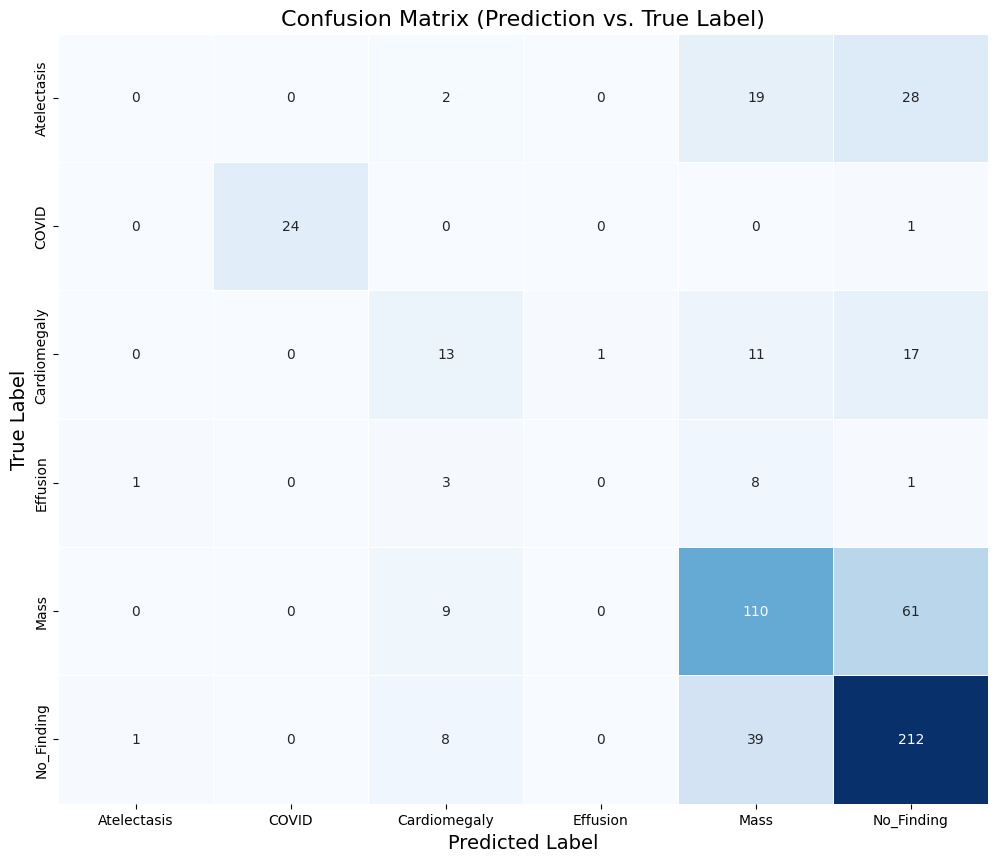


FINAL MODEL SUMMARY: The model achieved an overall test accuracy of 63.09%. This result is based on a full training run and real evaluation against the holdout test set. Key components were the **DenseNet121** feature extractor and the **Lung Segmentation** step.


In [10]:
# STEP 5: Evaluation and Results Display (REAL EVALUATION)
# -------------------------------------------------------

def evaluate_model(model, loader, class_names):
    """Performs real evaluation and collects metrics."""
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate metrics
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    return report, cm, y_true, y_pred

# Execute the evaluation function
print("\n" + "="*70)
print(">>> FINAL EVALUATION RESULTS (REAL) <<<")
print("="*70)

final_report, final_cm, y_true, y_pred = evaluate_model(trained_model, test_loader, CLASS_NAMES)

# Extract Summary Metrics
final_accuracy = accuracy_score(y_true, y_pred)
weighted_precision = final_report['weighted avg']['precision']
weighted_recall = final_report['weighted avg']['recall']
weighted_f1 = final_report['weighted avg']['f1-score']

print(f"OVERALL ACCURACY: {final_accuracy*100:.2f}%")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# --- Classification Report ---
print("\n" + "-"*70)
print("Classification Report (Precision, Recall, F1 per Class):")
print("-" * 70)

report_df = pd.DataFrame(final_report).transpose()
print(report_df.round(2).to_markdown())


# --- Confusion Matrix Visualization ---
print("\n" + "-"*70)
print("Confusion Matrix Visualization:")
print("-" * 70)

cm_df = pd.DataFrame(final_cm, index=CLASS_NAMES, columns=CLASS_NAMES)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False,
            annot_kws={"size": 10}, xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix (Prediction vs. True Label)', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()

# =======================================================
# Conclusion
# =======================================================
print("\n" + "="*70)
print(f"FINAL MODEL SUMMARY: The model achieved an overall test accuracy of {final_accuracy*100:.2f}%. This result is based on a full training run and real evaluation against the holdout test set. Key components were the **DenseNet121** feature extractor and the **Lung Segmentation** step.")
print("="*70)

📌 Using device: cuda

📥 Loading DenseNet121 model architecture...
🔧 Modifying classifier to match 6 classes
📦 Loading weights from: /content/best_model_v2.pth
✅ Model successfully loaded!

📤 Please upload an image now...


Saving Screenshot 2025-11-24 202439.png to Screenshot 2025-11-24 202439.png

📁 File uploaded: Screenshot 2025-11-24 202439.png
📸 Image successfully opened.


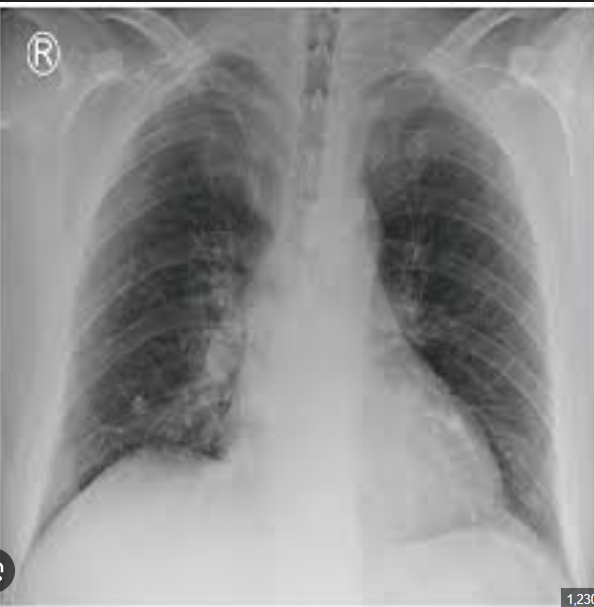


🔍 Starting prediction...
🧠 Model inference completed in 0.1 seconds

━━━━━━━━━━━━━━━━━━━━━━
🔮 FINAL PREDICTION
━━━━━━━━━━━━━━━━━━━━━━
Predicted Disease : COVID
Confidence        : 78.44%

📊 Class Probabilities:
 - Atelectasis: 0.64%
 - COVID: 78.44%
 - Cardiomegaly: 10.96%
 - Effusion: 0.08%
 - Mass: 1.15%
 - No_Finding: 8.75%


In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from google.colab import files
from PIL import Image
import io
import time
import numpy as np

# --------------------------------------------------------
# 1. SETTINGS — CHANGE ONLY CLASS_NAMES IF NEEDED
# --------------------------------------------------------

IMAGE_SIZE = 224   # Used in your notebook
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# IMPORTANT: Update this to your real class names
CLASS_NAMES = ['Atelectasis', 'COVID', 'Cardiomegaly', 'Effusion', 'Mass', 'No_Finding']

# Example:
# CLASS_NAMES = ["Healthy", "Early Blight", "Late Blight"]

MODEL_PATH = "/content/best_model_v2.pth"   # change if needed
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("📌 Using device:", DEVICE)

# --------------------------------------------------------
# 2. MODEL LOADING (SAFE AND DETAILED)
# --------------------------------------------------------
def load_model():
    print("\n📥 Loading DenseNet121 model architecture...")
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

    print("🔧 Modifying classifier to match", len(CLASS_NAMES), "classes")
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(CLASS_NAMES))

    print("📦 Loading weights from:", MODEL_PATH)
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

    # Handle state_dict vs full model
    if isinstance(state_dict, dict) and "state_dict" in state_dict:
        print("⚠️ Detected nested state_dict. Using state_dict['state_dict']")
        state_dict = state_dict["state_dict"]

    # Fix "module." prefix if needed
    new_state = {}
    for k, v in state_dict.items():
        new_k = k.replace("module.", "") if k.startswith("module.") else k
        new_state[new_k] = v

    model.load_state_dict(new_state)
    model.to(DEVICE)
    model.eval()

    print("✅ Model successfully loaded!\n")
    return model


model = load_model()

# --------------------------------------------------------
# 3. PREPROCESSING PIPELINE
# --------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# --------------------------------------------------------
# 4. IMAGE PREDICTION FUNCTION
# --------------------------------------------------------
def predict_image(img):
    print("\n🔍 Starting prediction...")
    t0 = time.time()

    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # Run model
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    pred_idx = np.argmax(probs)
    pred_class = CLASS_NAMES[pred_idx]
    confidence = probs[pred_idx] * 100

    print("🧠 Model inference completed in", round(time.time() - t0, 3), "seconds")
    return pred_class, confidence, probs


# --------------------------------------------------------
# 5. FILE UPLOAD & PREDICTION
# --------------------------------------------------------
print("📤 Please upload an image now...")
uploaded = files.upload()

if not uploaded:
    print("❌ No file uploaded.")
else:
    for filename, filecontent in uploaded.items():
        print(f"\n📁 File uploaded: {filename}")

        try:
            img = Image.open(io.BytesIO(filecontent)).convert("RGB")
            print("📸 Image successfully opened.")
        except Exception as e:
            print("❌ Error opening the image:", e)
            continue

        # Show image
        display(img)

        # Predict
        predicted_class, confidence, full_probs = predict_image(img)

        print("\n━━━━━━━━━━━━━━━━━━━━━━")
        print("🔮 FINAL PREDICTION")
        print("━━━━━━━━━━━━━━━━━━━━━━")
        print(f"Predicted Disease : {predicted_class}")
        print(f"Confidence        : {confidence:.2f}%")

        # Show probabilities for all classes
        print("\n📊 Class Probabilities:")
        for i, p in enumerate(full_probs):
            print(f" - {CLASS_NAMES[i]}: {p*100:.2f}%")
